In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt

from bluesky.plans import adaptive_scan, scan, tune_centroid
from bluesky.callbacks import LiveFit, LivePlot, LiveFitPlot, LiveTable
from bluesky.callbacks.fitting import PeakStats
from bluesky.callbacks.best_effort import BestEffortCallback as bec
from bluesky.preprocessors import subs_decorator
from bluesky import RunEngine
from ophyd.signal import EpicsSignalRO, EpicsSignal
from ophyd.epics_motor import EpicsMotor

#Need for testing/troubleshooting
from ophyd.sim import SynAxis, SynGauss, SynSignal

#For fitting
import lmfit
import numpy as np
import scipy
import math 

In [2]:
class SynErfGauss(SynSignal):
       
    def __init__(self, name, motor, motor_field, Imax, wid, x0,
                 noise=None, noise_multiplier=1, **kwargs):
        if noise not in ('poisson', 'uniform', None):
            raise ValueError("noise must be one of 'poisson', 'uniform', None")
        self._motor = motor

        def func():
            m = motor.read()[motor_field]['value']
            v = erfx(m, 0, Imax, wid, x0)
            v += gaussian(m, Imax*0.20, 0.1, x0 + 1 - wid/2.0 + 0.25*np.random.random())
            if noise == 'poisson':
                v = int(np.random.poisson(np.round(v), 1))
            elif noise == 'uniform':
                v += np.random.uniform(-1, 1) * noise_multiplier
            return v

        super().__init__(func=func, name=name, **kwargs)

In [3]:
def gaussian(x, A, sigma, x0):
    return A*np.exp(-(x - x0)**2/(2 * sigma**2))
    
def erfx(x, low, high, wid, x0):
    return (high - low) * 0.5 * (1-scipy.special.erf((x-x0)/wid)) + low   

In [4]:
fit_colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
linestyles = ['-', '--', '-.', ':']

def_xAlignRange = [-1.00, 2.00]
def_xStepRange = [0.0015, 0.1]
def_xTargetDelta = 0.0025
def_fudge = 0.75
def_thAlignRange = [4.0,6.0]
def_thCoarseStep = 0.1 
def_thFineRadius = 0.2 
def_thStepRange = [0.015, 0.1]	#min thMotor step is 0.01 degrees
def_thTargetDelta = 0.1

In [5]:
try:
    thAlignRange = theta_kws['alignRange'] 
except:
    thAlignRange = def_thAlignRange 

In [6]:
xMotor = SynAxis(name='xMotor')
simX0 = np.random.random()-0.5
thMotor = SynAxis(name='thMotor')
simCenter = (thAlignRange[1]-thAlignRange[0])*np.random.random() + thAlignRange[0]
detTh = SynGauss('detTh',thMotor, 'thMotor', center=simCenter, Imax=1, sigma=.03, noise='uniform', noise_multiplier=0.05)
detX = SynErfGauss('detX', xMotor, 'xMotor', Imax=0.024, wid=0.20, x0 = simX0, noise='uniform', noise_multiplier=0.0005)

In [ ]:
RE = RunEngine({})

In [ ]:
xLivePlot = LivePlot('detX',x='xMotor')
xLiveTable = LiveTable([detX, xMotor])

xCbs = [xLivePlot, xLiveTable]

In [ ]:
@subs_decorator(xCbs)
def multiScan(detectors, motor, fRange = [-0.5, 0.5], cRange = [-1.0, 2.0], coarse=10, fine=50):
    yield from scan(detectors, motor, cRange[0], cRange[1], num = coarse)
    yield from scan(detectors, motor, fRange[0], fRange[1], num = fine)

In [ ]:
RE(multiScan([detX], xMotor))

### Simple Coarse/Fine scan with plots

In [ ]:
fix, ax = plt.subplots()

@subs_decorator(xLiveTable)
def multiScan(iter_count, detectors, motor, fRange = [-0.5, 0.5], cRange = [-1.0, 2.0], coarse=10, fine=50):
    for iteration in np.arange(iter_count):
        cur_color = fit_colors[iteration % len(fit_colors)]
        finePlot = LivePlot('detX',x='xMotor', markeredgecolor = cur_color, markerfacecolor = 'none', 
                            ax = ax, linestyle = 'none', marker = 'o', label = '{} - fine'.format(iteration))
        coarsePlot = LivePlot('detX',x='xMotor', linestyle = 'none', marker = '^', markerfacecolor = 'none',
                              markeredgecolor = cur_color, ax = ax, label = '{} - coarse'.format(iteration))
        
        @subs_decorator(coarsePlot)
        def coarseScan(detectors, motor, cRange, pts = 10):
            yield from scan(detectors, motor, cRange[0], cRange[1], num = pts)
    
        @subs_decorator(finePlot)
        def fineScan(detectors, motor, fRange, pts = 50):
            yield from scan(detectors, motor, fRange[0], fRange[1], num = pts)

        yield from coarseScan(detectors, motor, cRange, pts = coarse)
        yield from fineScan(detectors, motor, fRange, pts = fine)

In [ ]:
RE(multiScan(4, [detX], xMotor))

### Simple Scan with Fit after the fact and return of centroid
The following code doesn't seem significantly cleaner then the earlier code

In [ ]:
fig2, bx = plt.subplots()

def fitAndPlotBumplessData(y, x, x0, width, fudge = 0.5, ax = ax, color = 'r', linestyle = '-'): 
    x_reduced_max = x0 + fudge - 0.5*width

    xdata = np.asarray(x)
    ydata = np.asarray(y)
    ix = np.where(xdata < x_reduced_max)

    x_reduced = xdata[ix]
    y_reduced = ydata[ix]

    red_model = lmfit.Model(erfx, missing = 'drop')
    red_guess = {'low': min(y_reduced),
                 'high': max(y_reduced),
                 'wid': lmfit.Parameter('wid', value = width, min=0),
                 'x0': x0}

    params = red_model.make_params(low = min(y_reduced), high = max(y_reduced), 
                                   wid = width, x0 = x0)

    redFit = red_model.fit(y_reduced, params, x = x_reduced)
    redFit_x0 = redFit.result.params['x0'].value
    redFit_width = redFit.result.params['wid'].value

    #plot new fit
    redFit.plot_fit(ax = ax, data_kws = {'visible':False}, 
                    fit_kws={'color': color, 
                             'linestyle' : linestyle},
                    init_kws={'visible':False},
                    xlabel = 'xMotor', ylabel = 'detX')
    ax.set_title(' ')

    return redFit_x0


@subs_decorator(xLiveTable)
def ScanThenFit(iter_count, detector, det_name, motor, motor_name, fRange = [-1, 2], cRange = [-1.0, 2.0], pts = 50):
    for iteration in np.arange(iter_count):
        cur_color = fit_colors[iteration % len(fit_colors)]
        cur_linestyle = linestyles[iteration // len(fit_colors)]

        scanPlot = LivePlot('detX',x='xMotor', markeredgecolor = cur_color, markerfacecolor = 'none', 
                            ax = bx, linestyle = 'none', marker = 'o', label = '{} - data'.format(iteration))
        
        comp_model = lmfit.Model(erfx, prefix="erf_") + lmfit.Model(gaussian, prefix = "gau_")
        comp_guess = {'erf_low': 0,
                      'erf_high': 0.03,
                      'erf_wid': lmfit.Parameter('erf_wid', value = 0.4, min=0),
                      'erf_x0': -0.1,
                      'gau_A': 0.01,
                      'gau_sigma': lmfit.Parameter('gau_sigma', value = .1, min=0),
                      'gau_x0': 1.0}
        xLiveFit = LiveFit(comp_model, det_name, {'x': motor_name}, comp_guess, update_every=5)
                
        @subs_decorator([scanPlot, xLiveFit])
        def preFitScan(detectors, motor, fRange, pts = 50):
            yield from scan(detectors, motor, fRange[0], fRange[1], num = pts)

        yield from preFitScan(detector, motor, fRange)

        x0_rough = xLiveFit.result.params['erf_x0'].value
        width = xLiveFit.result.params['erf_wid'].value
        
        x0 = fitAndPlotBumplessData(np.asarray(finePlot.y_data), np.asarray(finePlot.x_data), x0_rough, width,
                               ax = bx, color = cur_color, linestyle = cur_linestyle)
        print(x0)
        

In [ ]:
RE(ScanThenFit(4, [detX], 'detX', xMotor, 'xMotor'))

### Simple Scan with Fit after the fact, return of inflection, make inflection available for next scan (xScan)


### AdaptiveScan with Fit after the fact and return of inflection (xScan)


### Trying Tune Centroid (thetaScan)

In [ ]:
RE = RunEngine({})

In [ ]:
thLivePlot = LivePlot('detTh',x='thMotor')
thLiveTable = LiveTable([detTh, thMotor])
thCbs = [thLivePlot, thLiveTable]

In [ ]:
print(simCenter)
RE(tune_centroid([detTh],'detTh',thMotor, 4, 6, 0.01, 100), thCbs)

Tune Centroid won't due to small back step (< 1 degree)

### Coarse scan with max return + fine (adaptive scan) about peak (thetaScan)

In [7]:
RE = RunEngine({})

In [8]:
thLiveTable = LiveTable([detTh, thMotor])

<IPython.core.display.Javascript object>


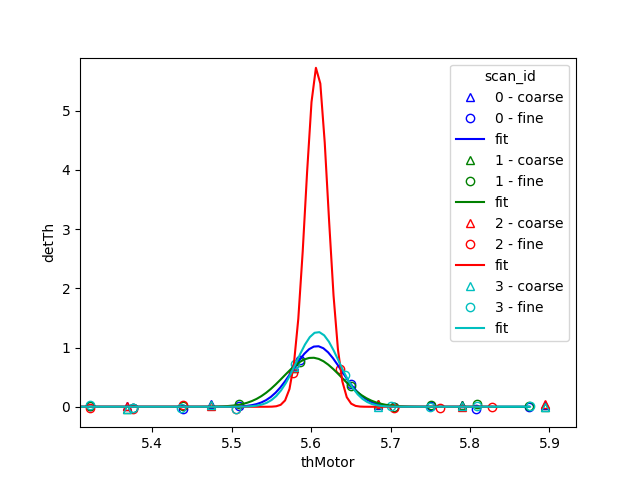

In [19]:
fix, dx = plt.subplots()


@subs_decorator(thLiveTable)
def multiScan(iter_count, detectors, motor, fRange = [4, 6], cRange = [4, 6], coarse=20, fineRadius=0.3, 
             fStepRange = [0.015, 0.1]):
    for iteration in np.arange(iter_count):
        cur_color = fit_colors[iteration % len(fit_colors)]
        finePlot = LivePlot('detTh',x='thMotor', markeredgecolor = cur_color, markerfacecolor = 'none', 
                            ax = dx, linestyle = 'none', marker = 'o', label = '{} - fine'.format(iteration))
        coarsePlot = LivePlot('detTh',x='thMotor', linestyle = 'none', marker = '^', markerfacecolor = 'none',
                              markeredgecolor = cur_color, ax = dx, label = '{} - coarse'.format(iteration))
        coarsePeak = PeakStats('thMotor','detTh')

        @subs_decorator([coarsePlot,coarsePeak])
        def coarseScan(detectors, motor, cRange, pts = 10):
            yield from scan(detectors, motor, cRange[0], cRange[1], num = pts)
        
        yield from coarseScan(detectors, motor, cRange, pts = coarse)

        finePlot = LivePlot('detTh',x='thMotor', linestyle = 'none', marker = 'o', markerfacecolor = 'none',
                              markeredgecolor = cur_color, ax = dx, label = '{} - fine'.format(iteration))
        fineThetaModel = lmfit.Model(gaussian)
        fineThetaInitGuess = {'A': coarsePeak.max[1], 
                              'sigma': lmfit.Parameter('sigma', .03, min=0),
                              'x0': coarsePeak.max[0]}
        fineThetaLiveFit = LiveFit(fineThetaModel, 'detTh', {'x': 'thMotor'}, fineThetaInitGuess, update_every=1)
        fineThetaLiveFitPlot = LiveFitPlot(fineThetaLiveFit, ax = dx, label='fit', color = fit_colors[iteration % 7],
                                       linestyle = linestyles[iteration // 7])
        
        fRange = [coarsePeak.max[0]-fineRadius, coarsePeak.max[0]+fineRadius]
      
        @subs_decorator([finePlot, fineThetaLiveFitPlot])
        def fineScan(detectors, motor, fRange, pts = 50):
            yield from adaptive_scan(detectors, 'detTh', motor, start = fRange[0], stop = fRange[1], 
                                     min_step = fStepRange[0], max_step = fStepRange[1], 
                                     target_delta = def_thTargetDelta, backstep = False)
    
        yield from fineScan(detectors, motor, fRange)

In [20]:
RE(multiScan(4, [detTh], thMotor))

+-----------+------------+------------+------------+------------------+
|   seq_num |       time |      detTh |    thMotor | thMotor_setpoint |
+-----------+------------+------------+------------+------------------+
|         1 | 09:55:52.5 |     -0.048 |      4.000 |            4.000 |
|         2 | 09:55:52.5 |      0.006 |      4.105 |            4.105 |
|         3 | 09:55:52.5 |     -0.008 |      4.211 |            4.211 |
|         4 | 09:55:52.6 |      0.022 |      4.316 |            4.316 |
|         5 | 09:55:52.6 |     -0.020 |      4.421 |            4.421 |
|         6 | 09:55:52.6 |      0.002 |      4.526 |            4.526 |
|         7 | 09:55:52.6 |     -0.037 |      4.632 |            4.632 |
|         8 | 09:55:52.6 |      0.026 |      4.737 |            4.737 |
|         9 | 09:55:52.6 |     -0.033 |      4.842 |            4.842 |
|        10 | 09:55:52.6 |     -0.037 |      4.947 |            4.947 |
|        11 | 09:55:52.7 |      0.006 |      5.053 |            

|         8 | 09:55:56.3 |     -0.028 |      5.705 |            5.705 |
|         9 | 09:55:56.4 |     -0.026 |      5.762 |            5.762 |
|        10 | 09:55:56.5 |     -0.008 |      5.828 |            5.828 |
+-----------+------------+------------+------------+------------------+
generator adaptive_scan ['abe9e3'] (scan num: 46)
+-----------+------------+------------+------------+------------------+
|   seq_num |       time |      detTh |    thMotor | thMotor_setpoint |
+-----------+------------+------------+------------+------------------+
|         1 | 09:55:56.7 |      0.023 |      4.000 |            4.000 |
|         2 | 09:55:56.7 |      0.001 |      4.105 |            4.105 |
|         3 | 09:55:56.7 |      0.013 |      4.211 |            4.211 |
|         4 | 09:55:56.7 |      0.028 |      4.316 |            4.316 |
|         5 | 09:55:56.8 |     -0.007 |      4.421 |            4.421 |
|         6 | 09:55:56.8 |      0.050 |      4.526 |            4.526 |
|         7 | 

('5971adf5-8f85-4280-941a-459245631479',
 '66ae1df1-426d-4fc7-b48e-ae2432316a6c',
 '56c35e13-79bd-4952-a8c4-1a70345af635',
 '47d9724d-9230-41da-b7e3-8781e6e74e2c',
 'ad64a8ea-2ab7-4ad9-b969-2795a380b9c5',
 'abe9e36f-bd2a-404a-93f0-a36e0e1ddd9f',
 '6d80e267-3cbb-4ec8-baa6-5105149d3e60',
 '369c0c1e-ca04-4c17-a7b3-230d98880eba')

### Coarse scan with max return + fine (adaptive scan) about peak + return peak location (thetaScan)